# Timeseries classification with a Transformer model

**Author:** [Theodoros Ntakouris](https://github.com/ntakouris)<br>
**Date created:** 2021/06/25<br>
**Last modified:** 2021/08/05<br>
**Description:** This notebook demonstrates how to do timeseries classification using a Transformer model.

# Introduction

This is the Transformer architecture from
[Attention Is All You Need](https://arxiv.org/abs/1706.03762),
applied to timeseries instead of natural language.

This example requires TensorFlow 2.4 or higher.

## Load the dataset

We are going to use the same dataset and preprocessing as the
[TimeSeries Classification from Scratch](https://keras.io/examples/timeseries/timeseries_classification_from_scratch)
example.

In [1]:
import os
import sys
import csv
import math
import json
import glob
import random
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from scipy import interpolate
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

%matplotlib inline

# sys.path.append(os.path.abspath(".."))
# import scripts.compensate
# import scripts.kinectImg2video
# from scripts.conpemsate_suppresser import *
# from scripts.ground_angle_analysis import ground_shoulder_angle_analyzer
# import scripts.ground_angle_analysis

In [2]:
# Setup seeds
torch.manual_seed(1234)
np.random.seed(1234)
random.seed(1234)

In [6]:
l_filepath = sorted(glob.glob("/Users/kento/kuhp/research/Kinect_data/1103_act_myself/jointdata_csv/*.csv"))
# l_filepath = sorted(glob.glob("/content/drive/MyDrive/research/Kinect_data/1103_act_myself/jointdata_csv/*.csv"))

In [8]:
# def read_csv(file_name):
#     l_all_data = []
#     with open(l_filepath[0], encoding='utf8') as f:
#         csvreader = csv.reader(f)
#         for row in csvreader:
#             l_all_data.append(row)
#     return l_all_data

In [9]:
#ファイル名からスコアを取得して，dfを返す関数 
def read_csv_add_score(filepath):
    df = pd.read_csv(filepath, header=None)
    #スコアの取得
    score = filepath.split("-")[1].split('.')[0]
    df['score'] = score
    return df

def interpolate_df(df):
    l = []
    for i in range(98):
        y_raw = df[i]
        length = len(y_raw)

        #rawデータを乗せる0→1のベクトルを作成する
        second_raw = np.linspace(0, 1, length)

        #新しく生成される0→1のベクトル(要素数200)
        second_new = np.linspace(0, 1, 200)

        f = interpolate.interp1d(second_raw, y_raw, kind='cubic')
        y_new = f(second_new)
        l.append(y_new)
    df_new = pd.DataFrame(l).T
    df_new['score'] = df['score'].mode()[0]
    return df_new
    
def extract_joint(df, joint_name):
    dic = joint_dict()
    joint_id = dic[joint_name]
    df_ex = df.loc[:, [joint_id, joint_id+1, joint_id+2]]
    df_ex['score'] = df['score'].mode()[0] #scoreを引き継ぐ
    return df_ex

# 内部メソッド
def joint_dict():
    dic = {'Pelvis':2,'SpineNaval':5,'SpineChest':8, 'Neck':11, 'LClavicle':14, 'LShoulder':17, 'LElbow':20, 'LWrist':23, 'LHand':26, 'LHandTip':29, 
           'LThumb':32, 'RClavicle':35, 'RShoulder':38, 'RElbow':41, 'RWrist':44, 'RHand':47, 'RHandTip':50, 'RThumb':53, 'LHip':56, 'LKnee':59, 
           'LAnkle':62, 'LFoot':65, 'RHip':68, 'RKnee':71, 'RAnkle':74, 'RFoot':77, 'Head':80, 'Nose':83, 'LEye':86, 'LEar':89, 'REye':92, 'REar':95}
    return dic

def zscore(x, axis = None):
    xmean = x.mean(axis=axis, keepdims=True)
    xstd  = np.std(x, axis=axis, keepdims=True)
    zscore = (x-xmean)/xstd
    return zscore

In [10]:
def create_pos_dataset(l_filepath, joint1_name, joint2_name):
    for filepath in l_filepath:
        df = read_csv_add_score(filepath)
        df = interpolate_df(df)
        dataset_joint1 = extract_joint(df, joint1_name)
        dataset_joint2 = extract_joint(df, joint2_name)
        
        #複数のデータ間でscoreのndarray を作成する種
        y_one = np.array([dataset_joint1['score'].mode()[0]], dtype=np.int64)
        if 'y' in locals():
            y = np.concatenate([y, y_one])
        else:
            y = y_one

        #複数のデータ間で X データセットを作成する種
        joint1 = dataset_joint1.iloc[:, 0:3].to_numpy()
        joint1 = np.expand_dims(joint1, axis=0)

        joint2 = dataset_joint2.iloc[:, 0:3].to_numpy()
        joint2 = np.expand_dims(joint2, axis=0)

        X_one = joint1 - joint2
        
        # Xにノルムを追加する
        norm = np.linalg.norm(X_one, axis=2,ord=2)
        norm = norm.reshape((1,-1,1))
        X_one = np.concatenate((X_one, norm), axis=2)

        if 'X' in locals():
            X = np.concatenate([X, X_one])
        else:
            X = X_one
            
    return X, y

In [11]:
X, y = create_pos_dataset(l_filepath, 'Neck', 'Pelvis')
# 3分類
# condition = y == 2
# y[condition] = 0
# condition = y == 25
# y[condition] = 1
# condition = y == 3
# y[condition] = 2
# # y[~condition] = 0

# 二値分類
condition = y == 3
y[condition] = 1
y[~condition] = 0

X = zscore(X, axis=1)

X = zscore(X, axis=1)

In [12]:
from sklearn.preprocessing import OneHotEncoder
# from tensorflow.keras.utils import to_categorical


n_classes = len(np.unique(y))
print(n_classes)

# y_categorical = to_categorical(y)
# enc = OneHotEncoder(categories="auto", sparse=False, dtype=np.float32)
# onehot_y = enc.fit_transform(y)


# x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.01, random_state=40) #splitバージョン 
x_train, y_train = X, y #splitしないバージョン


### 先頭にclassification用のトークンを追加する
score_train = np.zeros((x_train.shape[0], 1 , x_train.shape[2]))
x_train = np.concatenate([score_train, x_train], axis=1)

2


## PyTorchのdatasetの作成


In [13]:
print(x_train.shape)

(60, 201, 4)


In [14]:
X = torch.tensor(x_train, dtype=torch.float32)
y = torch.tensor(y_train, dtype=torch.int64)

In [15]:
dataset = torch.utils.data.TensorDataset(X, y)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=4)

In [16]:
dataloaders_dict = {"train": dataloader, "val": dataloader}

In [17]:
batch = next(iter(dataloader))
print(batch[0].max())
print(batch[0].min())

tensor(3.5083)
tensor(-3.6083)


In [18]:
# import matplotlib.pyplot as plt

# classes = np.unique(y, axis=0)
# print(classes)

# fig = plt.figure(figsize=(10, 15))

# # 各点のプロットを行う
# for i, item in enumerate([0, 10, 20]):
#     c_x_train = x_train[item]
#     # print(f"class is {np.argmax(y_train[item])}")
#     fig.add_subplot(3, 1, i+1)
#     plt.plot(c_x_train[:, :], label=["x", "y", "z"])
#     plt.title(f"score {y_train[item]}")
#     plt.legend(loc="best")
#     plt.grid()

# # 各点のプロットを行う
# # c_x_train = x_train[10]
# # print(f"class is {np.argmax(y_train[11])}")
# # fig.add_subplot(3, 1, 2)
# # plt.plot(c_x_train[:, :], label=["x", "y", "z"])
# # plt.legend(loc="best")
# # plt.grid()


# plt.show()
# plt.close()

In [19]:
# print(y_train)

In [20]:
# x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))
# x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], 1))

n_classes = len(np.unique(y_train))
n_classes = 3
print(n_classes)

idx = np.random.permutation(len(x_train))
x_train = x_train[idx]
y_train = y_train[idx]

# y_train[y_train == -1] = 0
# y_test[y_test == -1] = 0

3


## Build the model

Our model processes a tensor of shape `(batch size, sequence length, features)`,
where `sequence length` is the number of time steps and `features` is each input
timeseries.

You can replace your classification RNN layers with this one: the
inputs are fully compatible!

We include residual connections, layer normalization, and dropout.
The resulting layer can be stacked multiple times.

The projection layers are implemented through `keras.layers.Conv1D`.

In [21]:
class PositionalEncoder(nn.Module):
    '''入力された単語の位置を示すベクトル情報を付加する'''

    def __init__(self, d_model=300, max_seq_len=256):
        super().__init__()

        self.d_model = d_model  # 単語ベクトルの次元数

        # 単語の順番（pos）と埋め込みベクトルの次元の位置（i）によって一意に定まる値の表をpeとして作成
        pe = torch.zeros(max_seq_len, d_model)

        # GPUが使える場合はGPUへ送る、ここでは省略。実際に学習時には使用する
        # device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        # pe = pe.to(device)

        for pos in range(max_seq_len):
            for i in range(0, d_model, 2):
                pe[pos, i] = math.sin(pos / (10000 ** ((2 * i)/d_model)))
                
                # 誤植修正_200510 #79
                # pe[pos, i + 1] = math.cos(pos /
                #                          (10000 ** ((2 * (i + 1))/d_model)))
                pe[pos, i + 1] = math.cos(pos /
                                          (10000 ** ((2 * i)/d_model)))

        # 表peの先頭に、ミニバッチ次元となる次元を足す
        self.pe = pe.unsqueeze(0)

        # 勾配を計算しないようにする
        self.pe.requires_grad = False

    def forward(self, x):

        # 入力xとPositonal Encodingを足し算する
        # xがpeよりも小さいので、大きくする
        ret = math.sqrt(self.d_model)*x + self.pe
        return ret


In [23]:
# 動作確認

# モデル構築
net2 = PositionalEncoder(d_model=4, max_seq_len=201)

# 入出力
x1 = batch[0] 
print(x1.shape)
x2 = net2(x1)

print("入力のテンソルサイズ：", x1.shape)
print("出力のテンソルサイズ：", x2.shape)


torch.Size([4, 201, 4])
入力のテンソルサイズ： torch.Size([4, 201, 4])
出力のテンソルサイズ： torch.Size([4, 201, 4])


In [24]:
class Attention(nn.Module):
    def __init__(self, d_model=4):
        super().__init__()

        # SAGANでは1dConvを使用したが、今回は全結合層で特徴量を変換する
        self.q_linear = nn.Linear(d_model, d_model)
        self.v_linear = nn.Linear(d_model, d_model)
        self.k_linear = nn.Linear(d_model, d_model)

        # 出力時に使用する全結合層
        self.out = nn.Linear(d_model, d_model)

        # Attentionの大きさ調整の変数
        self.d_k = d_model

    def forward(self, q, k, v, mask):
        # 全結合層で特徴量を変換
        k = self.k_linear(k)
        q = self.q_linear(q)
        v = self.v_linear(v)

        # Attentionの値を計算する
        # 各値を足し算すると大きくなりすぎるので、root(d_k)で割って調整
        weights = torch.matmul(q, k.transpose(1, 2)) / math.sqrt(self.d_k)

        # ここでmaskを計算
        # mask = mask.unsqueeze(1)
        # print(mask)
        # weights = weights.masked_fill(mask == 0, -1e9)

        # softmaxで規格化をする
        normlized_weights = F.softmax(weights, dim=-1)

        # AttentionをValueとかけ算
        output = torch.matmul(normlized_weights, v)

        # 全結合層で特徴量を変換
        output = self.out(output)

        return output, normlized_weights


In [25]:
class FeedForward(nn.Module):
    def __init__(self, d_model, d_ff=1024, dropout=0.1):
        '''Attention層から出力を単純に全結合層2つで特徴量を変換するだけのユニットです'''
        super().__init__()

        self.linear_1 = nn.Linear(d_model, d_ff)
        self.dropout = nn.Dropout(dropout)
        self.linear_2 = nn.Linear(d_ff, d_model)

    def forward(self, x):
        x = self.linear_1(x)
        x = self.dropout(F.relu(x))
        x = self.linear_2(x)
        return x

In [26]:
class TransformerBlock(nn.Module):
    def __init__(self, d_model, dropout=0.1):
        super().__init__()

        # LayerNormalization層
        # https://pytorch.org/docs/stable/nn.html?highlight=layernorm
        self.norm_1 = nn.LayerNorm(d_model)
        self.norm_2 = nn.LayerNorm(d_model)

        # Attention層
        self.attn = Attention(d_model)

        # Attentionのあとの全結合層2つ
        self.ff = FeedForward(d_model)

        # Dropout
        self.dropout_1 = nn.Dropout(dropout)
        self.dropout_2 = nn.Dropout(dropout)

    def forward(self, x, mask):
        # 正規化とAttention
        x_normlized = self.norm_1(x)
        output, normlized_weights = self.attn(
            x_normlized, x_normlized, x_normlized, mask)
        
        x2 = x + self.dropout_1(output)

        # 正規化と全結合層
        x_normlized2 = self.norm_2(x2)
        output = x2 + self.dropout_2(self.ff(x_normlized2))

        return output, normlized_weights


In [27]:
# 動作確認

# 動作確認

# モデル構築
net2 = PositionalEncoder(d_model=4, max_seq_len=201)

# 入出力
x1 = batch[0] 
print(x1.shape)
x2 = net2(x1)

# モデル構築
net2 = PositionalEncoder(d_model=4, max_seq_len=201)
net3 = TransformerBlock(d_model=4)

# maskの作成
x = batch[0]
print(x.shape)
input_pad = 1  # 単語のIDにおいて、'<pad>': 1 なので
input_mask = (x != input_pad)

# 入出力
# x1 = net1(x)  # 単語をベクトルに
x2 = net2(x)  # Positon情報を足し算
print(f"x2 shape is {x2.shape}, input_mask shape is {input_mask.shape}")
x3, normlized_weights = net3(x2, input_mask)  # Self-Attentionで特徴量を変換

print("入力のテンソルサイズ：", x2.shape)
print("出力のテンソルサイズ：", x3.shape)
print("Attentionのサイズ：", normlized_weights.shape)

torch.Size([4, 201, 4])
torch.Size([4, 201, 4])
x2 shape is torch.Size([4, 201, 4]), input_mask shape is torch.Size([4, 201, 4])
入力のテンソルサイズ： torch.Size([4, 201, 4])
出力のテンソルサイズ： torch.Size([4, 201, 4])
Attentionのサイズ： torch.Size([4, 201, 201])


In [28]:
class ClassificationHead(nn.Module):
    '''Transformer_Blockの出力を使用し、最後にクラス分類させる'''

    def __init__(self, d_model=300, output_dim=2):
        super().__init__()

        # 全結合層
        self.linear = nn.Linear(d_model, output_dim)  # output_dimはポジ・ネガの2つ

        # 重み初期化処理
        nn.init.normal_(self.linear.weight, std=0.02)
        nn.init.normal_(self.linear.bias, 0)

    def forward(self, x):
        x0 = x[:, 0, :]  # 各ミニバッチの各文の先頭の単語の特徴量（300次元）を取り出す
        out = self.linear(x0)

        return out


In [29]:
# 動作確認

# ミニバッチの用意
batch = next(iter(dataloader))

# モデル構築
net2 = PositionalEncoder(d_model=4, max_seq_len=201)
net3 = TransformerBlock(d_model=4)
net4 = ClassificationHead(output_dim=2, d_model=4)

# 入出力
x = batch[0]
x2 = net2(x)  # Positon情報を足し算
x3, normlized_weights = net3(x2, input_mask)  # Self-Attentionで特徴量を変換
x4 = net4(x3)  # 最終出力の0単語目を使用して、分類0-1のスカラーを出力

print("x1のテンソルサイズ：", x1[0,0])
print("x2のテンソルサイズ：", x2[0,0])
print("x3のテンソルサイズ：", x3[0,0])
print("出力のテンソルサイズ：", x4.shape)


x1のテンソルサイズ： tensor([0., 0., 0., 0.])
x2のテンソルサイズ： tensor([0., 1., 0., 1.])
x3のテンソルサイズ： tensor([-0.0564,  0.8646, -0.2123,  0.5677], grad_fn=<SelectBackward0>)
出力のテンソルサイズ： torch.Size([4, 2])


In [46]:
# 最終的なTransformerモデルのクラス


class TransformerClassification(nn.Module):
    '''Transformerでクラス分類させる'''

    def __init__(self, d_model=4, max_seq_len=201, output_dim=2):
        super().__init__()

        # モデル構築
        self.net2 = PositionalEncoder(d_model=d_model, max_seq_len=max_seq_len)
        self.net3_1 = TransformerBlock(d_model=d_model)
        # self.net3_2 = TransformerBlock(d_model=d_model)
        self.net4 = ClassificationHead(output_dim=output_dim, d_model=d_model)

    def forward(self, x, mask):
        x2 = self.net2(x)  # Positon情報を足し算
        x3, normlized_weights_1 = self.net3_1(
            x2, mask)  # Self-Attentionで特徴量を変換
        # x3_2, normlized_weights_2 = self.net3_2(
        #     x3_1, mask)  # Self-Attentionで特徴量を変換
        x4 = self.net4(x3)  # 最終出力の0単語目を使用して、分類0-1のスカラーを出力
        return x4, normlized_weights_1, normlized_weights_2


## Train and evaluate

In [47]:
# 動作確認

# ミニバッチの用意
batch = next(iter(dataloader))

# モデル構築
net = TransformerClassification(
     d_model=4, max_seq_len=201, output_dim=2)

# 入出力
x = batch[0]
input_mask = (x != input_pad)
out, normlized_weights_1, normlized_weights_2 = net(x, input_mask)

print("出力のテンソルサイズ：", out.shape)
print("出力テンソルのsigmoid：", F.softmax(out, dim=1))


出力のテンソルサイズ： torch.Size([4, 2])
出力テンソルのsigmoid： tensor([[0.0746, 0.9254],
        [0.0749, 0.9251],
        [0.0745, 0.9255],
        [0.0748, 0.9252]], grad_fn=<SoftmaxBackward0>)


The main part of our model is now complete. We can stack multiple of those
`transformer_encoder` blocks and we can also proceed to add the final
Multi-Layer Perceptron classification head. Apart from a stack of `Dense`
layers, we need to reduce the output tensor of the `TransformerEncoder` part of
our model down to a vector of features for each data point in the current
batch. A common way to achieve this is to use a pooling layer. For
this example, a `GlobalAveragePooling1D` layer is sufficient.

In [49]:
# ネットワークの初期化を定義


def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Linear') != -1:
        # Liner層の初期化
        nn.init.kaiming_normal_(m.weight)
        if m.bias is not None:
            nn.init.constant_(m.bias, 0.0)


# 訓練モードに設定
net.train()

# TransformerBlockモジュールを初期化実行
net.net3_1.apply(weights_init)
# net.net3_2.apply(weights_init)


print('ネットワーク設定完了')


ネットワーク設定完了


In [56]:
# 損失関数の設定
criterion = nn.CrossEntropyLoss()
# nn.LogSoftmax()を計算してからnn.NLLLoss(negative log likelihood loss)を計算

# 最適化手法の設定
learning_rate = 1e-4
optimizer = optim.Adam(net.parameters(), lr=learning_rate)


In [57]:
# モデルを学習させる関数を作成


def train_model(net, dataloaders_dict, criterion, optimizer, num_epochs):

    # GPUが使えるかを確認
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print("使用デバイス：", device)
    print('-----start-------')
    # ネットワークをGPUへ
    net.to(device)

    # ネットワークがある程度固定であれば、高速化させる
    torch.backends.cudnn.benchmark = True

    # epochのループ
    for epoch in range(num_epochs):
        # epochごとの訓練と検証のループ
        for phase in ['train']:
        # for phase in ['train', 'val']:
            if phase == 'train':
                net.train()  # モデルを訓練モードに
            else:
                net.eval()   # モデルを検証モードに

            epoch_loss = 0.0  # epochの損失和
            epoch_corrects = 0  # epochの正解数

            # データローダーからミニバッチを取り出すループ
            for batch in (dataloaders_dict[phase]):
                # batchはTextとLableの辞書オブジェクト

                # GPUが使えるならGPUにデータを送る
                inputs = batch[0].to(device)  # 文章
                labels = batch[1].to(device)  # ラベル

                # optimizerを初期化
                optimizer.zero_grad()

                # 順伝搬（forward）計算
                with torch.set_grad_enabled(phase == 'train'):

                    # mask作成
                    input_pad = 1  # 単語のIDにおいて、'<pad>': 1 なので
                    input_mask = (inputs != input_pad)

                    # Transformerに入力
                    outputs, _, _ = net(inputs, input_mask)
                    loss = criterion(outputs, labels)  # 損失を計算

                    _, preds = torch.max(outputs, 1)  # ラベルを予測

                    # 訓練時はバックプロパゲーション
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                    # 結果の計算
                    epoch_loss += loss.item() * inputs.size(0)  # lossの合計を更新
                    # 正解数の合計を更新
                    epoch_corrects += torch.sum(preds == labels.data)

            # epochごとのlossと正解率
            epoch_loss = epoch_loss / len(dataloaders_dict[phase].dataset)
            epoch_acc = epoch_corrects.double(
            ) / len(dataloaders_dict[phase].dataset)

            print('Epoch {}/{} | {:^5} |  Loss: {:.4f} Acc: {:.4f}'.format(epoch+1, num_epochs,
                                                                           phase, epoch_loss, epoch_acc))

    return net


In [58]:
print(batch[0].shape)

torch.Size([60, 201, 4])


In [59]:
# 学習・検証を実行する 15分ほどかかります
num_epochs = 300
net_trained = train_model(net, dataloaders_dict,
                          criterion, optimizer, num_epochs=num_epochs)


使用デバイス： cpu
-----start-------
Epoch 1/300 | train |  Loss: 0.5236 Acc: 0.7000
Epoch 2/300 | train |  Loss: 0.5182 Acc: 0.7000
Epoch 3/300 | train |  Loss: 0.5344 Acc: 0.7833
Epoch 4/300 | train |  Loss: 0.5130 Acc: 0.7167
Epoch 5/300 | train |  Loss: 0.4966 Acc: 0.7500
Epoch 6/300 | train |  Loss: 0.4939 Acc: 0.7167
Epoch 7/300 | train |  Loss: 0.5260 Acc: 0.7167
Epoch 8/300 | train |  Loss: 0.5439 Acc: 0.6667
Epoch 9/300 | train |  Loss: 0.4647 Acc: 0.8000
Epoch 10/300 | train |  Loss: 0.5065 Acc: 0.7500
Epoch 11/300 | train |  Loss: 0.4741 Acc: 0.7000
Epoch 12/300 | train |  Loss: 0.4794 Acc: 0.7833
Epoch 13/300 | train |  Loss: 0.4494 Acc: 0.7500
Epoch 14/300 | train |  Loss: 0.5242 Acc: 0.7000
Epoch 15/300 | train |  Loss: 0.4697 Acc: 0.7500
Epoch 16/300 | train |  Loss: 0.4741 Acc: 0.7333
Epoch 17/300 | train |  Loss: 0.4245 Acc: 0.8167
Epoch 18/300 | train |  Loss: 0.4523 Acc: 0.7833
Epoch 19/300 | train |  Loss: 0.4570 Acc: 0.7333
Epoch 20/300 | train |  Loss: 0.4798 Acc: 0.7333

# SaveModel

In [60]:
# device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

net_trained.eval()   # モデルを検証モードに
net_trained.to(device)

epoch_corrects = 0  # epochの正解数

test_dataloader = torch.utils.data.DataLoader(dataset, batch_size=60)

for batch in (test_dataloader):  # testデータのDataLoader
    # batchはTextとLableの辞書オブジェクト
    
    # GPUが使えるならGPUにデータを送る
    inputs = batch[0].to(device)  # 文章
    labels = batch[1].to(device)  # ラベル

    # 順伝搬（forward）計算
    with torch.set_grad_enabled(False):

        # mask作成
        input_pad = 1  # 単語のIDにおいて、'<pad>': 1 なので
        input_mask = (inputs != input_pad)

        # Transformerに入力
        outputs, attn_weights1, attn_weights2 = net_trained(inputs, input_mask)
        _, preds = torch.max(outputs, 1)  # ラベルを予測

        # 結果の計算
        # 正解数の合計を更新
        epoch_corrects += torch.sum(preds == labels.data)

# 正解率
epoch_acc = epoch_corrects.double() / len(test_dataloader.dataset)

print('テストデータ{}個での正解率：{:.4f}'.format(len(test_dataloader.dataset),epoch_acc))


テストデータ60個での正解率：1.0000


In [83]:
print(X.shape)
print(np.array(X[0, 1:, 0]).shape)

torch.Size([60, 201, 4])
(200,)


(200,)


/Users/kento/miniforge3/envs/torch/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


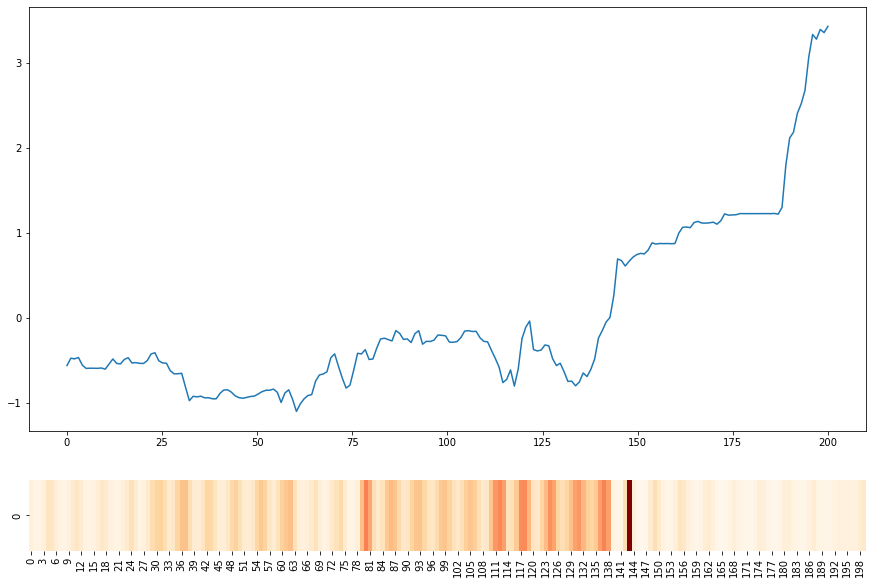

In [118]:
from matplotlib import gridspec

extract_data = np.array(X[0, 1:, 0]).flatten()
print(extract_data.shape)


time = np.linspace(0, 200, 200)
fig, ax = plt.subplots(2, 1, gridspec_kw={'height_ratios': [6, 1]}, figsize=(15,10))
# Set the palette using the name of a palette:
sns.lineplot(time, extract_data, ax=ax[0])
sns.heatmap(extract_weight, cmap='OrRd', cbar=False, ax=ax[1])

plt.show()

(200,)


/Users/kento/miniforge3/envs/torch/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


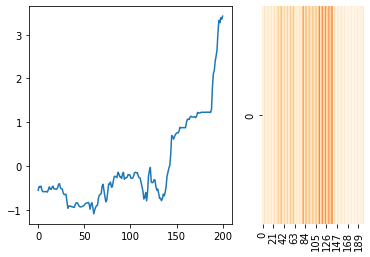

In [106]:
from matplotlib import gridspec

extract_data = np.array(X[0, 1:, 0]).flatten()
print(extract_data.shape)

time = np.linspace(0, 200, 200)


fig = plt.figure()
spec = gridspec.GridSpec(ncols=2, nrows=1,
                         widt=[2, 1])
# Set the palette using the name of a palette:
ax0 = fig.add_subplot(spec[0])
sns.lineplot(time, extract_data, ax=ax0)
ax1 = fig.add_subplot(spec[1])
sns.heatmap(extract_weight, cmap='OrRd', cbar=False, ax=ax1)

plt.show()

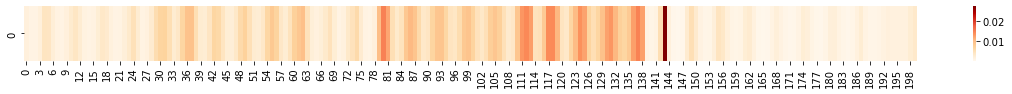

In [75]:
extract_weight = np.array(attn_weights1[0, 0, 1:]).reshape(1, -1)

fig, ax = plt.subplots(figsize=(20, 1))
# Set the palette using the name of a palette:
sns.heatmap(extract_weight, cmap='OrRd')
plt.show()

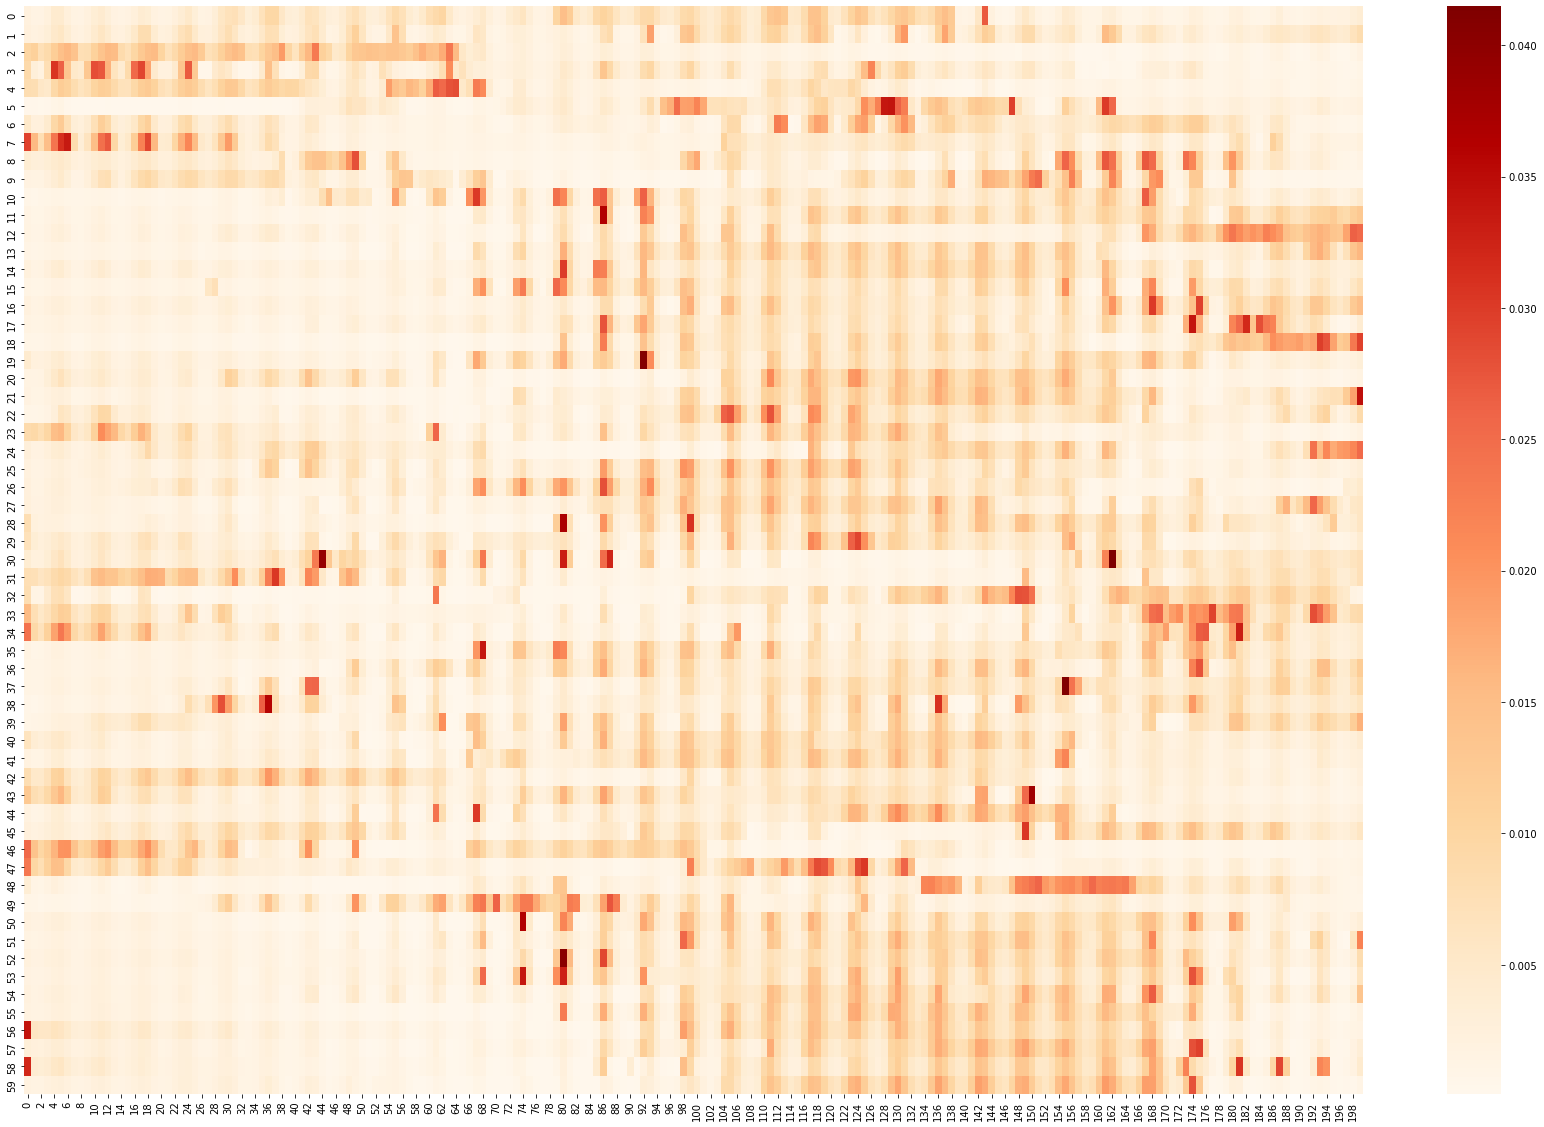

In [65]:
import seaborn as sns


data = np.array(attn_weights1[:, 0, 1:])
data = data.reshape(attn_weights1.shape[0], -1)

# print(outputs)
# print(data.shape)

fig, ax = plt.subplots(figsize=(30, 20))
# Set the palette using the name of a palette:
sns.heatmap(data, cmap='OrRd')
plt.show()

In [42]:
print(np.array(attn_weights1[0, 0, :]).shape)
print(attn_weights2[0, 0, :].shape)

(201,)
torch.Size([201])


In [ ]:
# HTMLを作成する関数を実装


def highlight(word, attn):
    "Attentionの値が大きいと文字の背景が濃い赤になるhtmlを出力させる関数"

    html_color = '#%02X%02X%02X' % (
        255, int(255*(1 - attn)), int(255*(1 - attn)))
    return '<span style="background-color: {}"> {}</span>'.format(html_color, word)


def mk_html(index, batch, preds, normlized_weights_1, normlized_weights_2, TEXT):
    "HTMLデータを作成する"

    # indexの結果を抽出
    sentence = batch.Text[0][index]  # 文章
    label = batch.Label[index]  # ラベル
    pred = preds[index]  # 予測

    # indexのAttentionを抽出と規格化
    attens1 = normlized_weights_1[index, 0, :]  # 0番目の<cls>のAttention
    attens1 /= attens1.max()

    attens2 = normlized_weights_2[index, 0, :]  # 0番目の<cls>のAttention
    attens2 /= attens2.max()

    # ラベルと予測結果を文字に置き換え
    if label == 0:
        label_str = "Negative"
    else:
        label_str = "Positive"

    if pred == 0:
        pred_str = "Negative"
    else:
        pred_str = "Positive"

    # 表示用のHTMLを作成する
    html = '正解ラベル：{}<br>推論ラベル：{}<br><br>'.format(label_str, pred_str)

    # 1段目のAttention
    html += '[TransformerBlockの1段目のAttentionを可視化]<br>'
    for word, attn in zip(sentence, attens1):
        html += highlight(TEXT.vocab.itos[word], attn)
    html += "<br><br>"

    # 2段目のAttention
    html += '[TransformerBlockの2段目のAttentionを可視化]<br>'
    for word, attn in zip(sentence, attens2):
        html += highlight(TEXT.vocab.itos[word], attn)

    html += "<br><br>"

    return html

# Extract model weights

In [ ]:
model.summary()

In [ ]:
from keras.models import Model
layer_name = 'multi_head_attention_10'
hidden_layer_model = Model(inputs=model.input, outputs=model.get_layer(layer_name).output)

In [ ]:
hidden_output = hidden_layer_model.predict(x_train)
hidden_output.shape

In [ ]:
weights = model.get_layer(layer_name).get_weights()
# print(weights)
print(type(weights))
print(len(weights))
print(weights[0].shape)
print(weights[0][0].shape)

In [ ]:
print(hidden_output[0, :, :])

## Conclusions

In about 110-120 epochs (25s each on Colab), the model reaches a training
accuracy of ~0.95, validation accuracy of ~84 and a testing
accuracy of ~85, without hyperparameter tuning. And that is for a model
with less than 100k parameters. Of course, parameter count and accuracy could be
improved by a hyperparameter search and a more sophisticated learning rate
schedule, or a different optimizer.

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

pred = model.predict(x_train)
# print(pred)
# print(y_test)
test_seed = np.argmax(y_train, axis=1)
onehot_pred_seed = np.argmax(pred, axis=1)
onehot_pred = np.zeros((len(y_train), n_classes))

for i in range(len(y_train)):
    onehot_pred[i, onehot_pred_seed[i]] = 1
print(onehot_pred)

plt.figure()
# sns.heatmap(pred)

labels = sorted(list(set(test_seed)))
c_mtx = confusion_matrix(test_seed, onehot_pred_seed)
print(c_mtx)
df_cmx = pd.DataFrame(c_mtx, index=labels, columns=labels)

plt.figure(figsize = (10,7))
sns.heatmap(df_cmx, annot=True, cmap='Blues')
plt.show()

In [ ]:


pred = model.predict(x_test)
mask = pred[:, 0] > 0.7
print(mask)
prediction = np.ones(len(pred))
prediction[mask] = int(0)
print(prediction)
print(y_test)

# confusion_matrix(y_test, prediction)

In [ ]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_test, pred[:, 1])
plt.plot(fpr, tpr, marker='o')
plt.xlabel('FPR: False positive rate')
plt.ylabel('TPR: True positive rate')
plt.grid()
# plt.savefig('data/dst/sklearn_roc_curve.png')
